# Tabular GANs performance study

This notebook contains the code to reproduce the performance study of TVAE.

In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import re
#from sdv.tabular import CopulaGAN, CTGAN,TVAE
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, ConfusionMatrixDisplay

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
    """
    Plots the confusion matrix based on the predicted labels and actual labels.

    Args:
        labels (array-like): The actual labels.
        predictions (array-like): The predicted labels.
        p (float, optional): The probability threshold for classification. Defaults to 0.5.
    """
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [3]:
df_alleles = pd.read_csv('oncoth1_with_n_risk_alleles.csv')

In [4]:
df = pd.read_csv('development_db_score_oncothromb.csv')

In [5]:
df_alleles['VTE'] = df['VTE'].values

# Apply paper preprocess pipeline

In [6]:
gen_predictors = ['rs4524', 'rs6025', 'rs2232698', 'rs2227631', 'rs268', 'rs169713', 'rs11696364', 'rs5110','rs6003']

In [7]:
#Select the risk alleles of the selected features
alleles_ = []
for element in gen_predictors:
    alleles_.append(element + '_n_risk_alleles')
alleles_.append('VTE')
alleles_.append('id')
df_alleles = df_alleles[alleles_].dropna()

### Compute Genetic Risk Score

In [8]:
from sklearn.linear_model import LogisticRegression

y = df_alleles['VTE']
X = df_alleles.drop(columns=['VTE', 'id'])

model = LogisticRegression(fit_intercept = True)
model.fit(X, y)

GRS = (model.coef_ * X).sum(axis=1) + model.intercept_
df_alleles['GRS'] = GRS

## Clinical Variables

- very high risk -> stomach, pancreas
- high risk -> lung, lymphoma, gynelocoligal, blader, testicular
- low risk -> colorectal
- platelet count >= 350x10^9/L -> high risk
- leukocyte count >= 11x10^9/L -> high risk

In [9]:
import re

def map_column(row, clinical_dict):
    """
    Maps a given row to a clinical category based on a dictionary of patterns.

    Args:
        row (any): The input row to be mapped.
        clinical_dict (dict): A dictionary containing patterns as keys and clinical categories as values.

    Returns:
        str: The mapped clinical category if a match is found, otherwise 'No Clasificado'.
    """
    # Convert row to string
    row = str(row)

    # Iterate over key-value pairs in clinical_dict
    for key, value in clinical_dict.items():
        # Use re.match to check if the pattern in value[0] matches row
        if re.match(value[0], row):
            # Return the key if a match is found
            return key
    
    # Return 'No Clasificado' if no match is found
    return 'No Clasificado'

In [10]:
def preprocess_clinical_features(df):
    """
    Preprocesses the clinical features of a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing clinical features.

    Returns:
        pandas.DataFrame: The preprocessed DataFrame with modified clinical features.
    """
    # Select the relevant columns from the DataFrame
    df_clin = df.iloc[:, 1:21]

    # Get the column names of the selected columns
    cols_names_clin = df_clin.columns[1:]

    # Map 'primary_tumor_simplified' values to numeric categories
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Colorectal', 'primary_tumor_simplified'] = 0
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'NSCLC', 'primary_tumor_simplified'] = 1
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Oesophago-gastric', 'primary_tumor_simplified'] = 2
    df_clin.loc[df_clin['primary_tumor_simplified'] == 'Pancreatic', 'primary_tumor_simplified'] = 2

    # Map 'leukocytes' values to binary categories
    df_clin.loc[df_clin['leukocytes'] < 11000, 'leukocytes'] = 0
    df_clin.loc[df_clin['leukocytes'] >= 11000, 'leukocytes'] = 1

    # Map 'platelets' values to binary categories
    df_clin.loc[df_clin['platelets'] < 350000, 'platelets'] = 0
    df_clin.loc[df_clin['platelets'] >= 350000, 'platelets'] = 1

    # Define the BMI risk dictionary
    bmi_risk = {
        1: [r"(Obese: BMI > 30 kg/m2)|( Overweight: BMI ~25-29.9 Kg/m2)"],
        0: [r"(Normal: BMI ~ 18.5-24.9 Kg/m2)|(Underweight: BMI < 18.5 Kg/m2)"],
    }

    # Define the TNM stage detailed risk dictionary
    tnm_stage_detailed_risk = {
        1: [r"(IA)|(IB)"],
        2: [r"(IIB)|(IIA)|(IIC)"],
        3: [r"(III)|(IIIB)|(IIIA)|(IIIC)"],
        4: [r"(IVB)|(IVA)|(IV)"],
    }

    # Apply the map_column function to 'bmi_category' and 'tnm_stage_detailed' columns
    df_clin['bmi_category'] = df_clin['bmi_category'].apply(lambda x: map_column(x, bmi_risk))
    df_clin['tnm_stage_detailed'] = df_clin['tnm_stage_detailed'].apply(lambda x: map_column(x, tnm_stage_detailed_risk))

    return df_clin

In [11]:
df_clin = preprocess_clinical_features(df)

### Get the clinical variables following the paper (without p-value selection )

In [12]:
# Drop the variables that are not mentioned in the paper
df_clin = df_clin.drop(['pregnancy', 'oral_contraceptives', 'hemoglobin'], axis=1)
df_clin['id'] = df['id'].values

Select the predictors of the paper

In [13]:
clin_predictors = ['tnm_stage_detailed', 'bmi_category', 'primary_tumor_simplified', 'id', 'VTE']
df_clin = df_clin[clin_predictors]
pred = ['id', 'GRS', 'VTE']
predictors = df_alleles[pred]
df_ft = predictors.merge(df_clin, on=['id','VTE'])
df = df_ft.drop(['id'],axis=1)
df['primary_tumor_simplified'] = df['primary_tumor_simplified'].astype(int)

In [14]:
df.head()

,GRS,VTE,tnm_stage_detailed,bmi_category,primary_tumor_simplified
0,-0.309952,1,4,1,2
1,-1.015882,0,2,0,2
2,-0.994715,0,3,1,2
3,-2.016533,0,2,0,2
4,-1.283673,0,1,0,2


Dataset with duplicates

In [15]:
X_real_dupes = df.drop('VTE', axis=1)
y_real_dupes = df['VTE']

Dataset with no duplicates

In [16]:
df_no_dupes = df.drop_duplicates()
X_real_no_dupes = df_no_dupes.drop('VTE', axis=1)
y_real_no_dupes = df_no_dupes['VTE']

# Generate Data

In [17]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_no_dupes)

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


In [19]:
metadata_dict = metadata.to_dict()
metadata_obj = SingleTableMetadata.load_from_dict(metadata_dict)

In [25]:
metadata.update_column(
    column_name='VTE',
    sdtype='categorical')

In [27]:
metadata.update_column(
    column_name='tnm_stage_detailed',
    sdtype='categorical')

In [28]:
metadata.update_column(
    column_name='bmi_category',
    sdtype='categorical')

In [29]:
metadata.update_column(
    column_name='primary_tumor_simplified',
    sdtype='categorical')

In [30]:
metadata_dict = metadata.to_dict()
metadata_obj = SingleTableMetadata.load_from_dict(metadata_dict)

TVAE

In [32]:
synthesizer = TVAESynthesizer(metadata_obj, epochs = 1000, batch_size=30)
synthesizer.fit(df_no_dupes)

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\numerical.py:112: UserWarning: No rounding scheme detected for column 'GRS'. Data will not be rounded.
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


Save model

In [ ]:
#synthesizer.save(filepath='test_TVAE.pkl')

Load trained model

In [34]:
#synthesizer = TVAESynthesizer.load(filepath='test_TVAE.pkl')

Generate synthetic samples

In [35]:
synth_gen = synthesizer.sample(num_rows=150000)

# Evaluation

In [36]:
from sdv.evaluation.single_table import evaluate_quality
quality_report = evaluate_quality(
    real_data=df_no_dupes,
    synthetic_data=synth_gen,
    metadata=metadata_obj)

Creating report: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.82it/s]



Overall Quality Score: 94.34%

Properties:
Column Shapes: 96.95%
Column Pair Trends: 91.73%


IPython not installed.


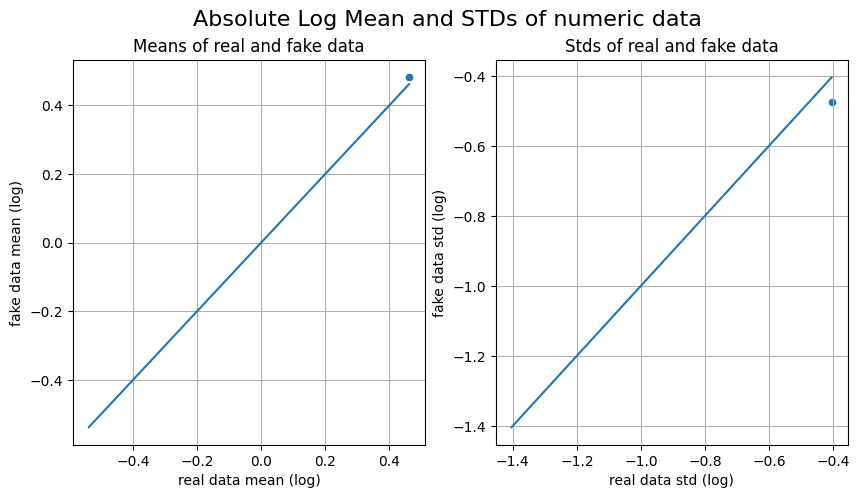

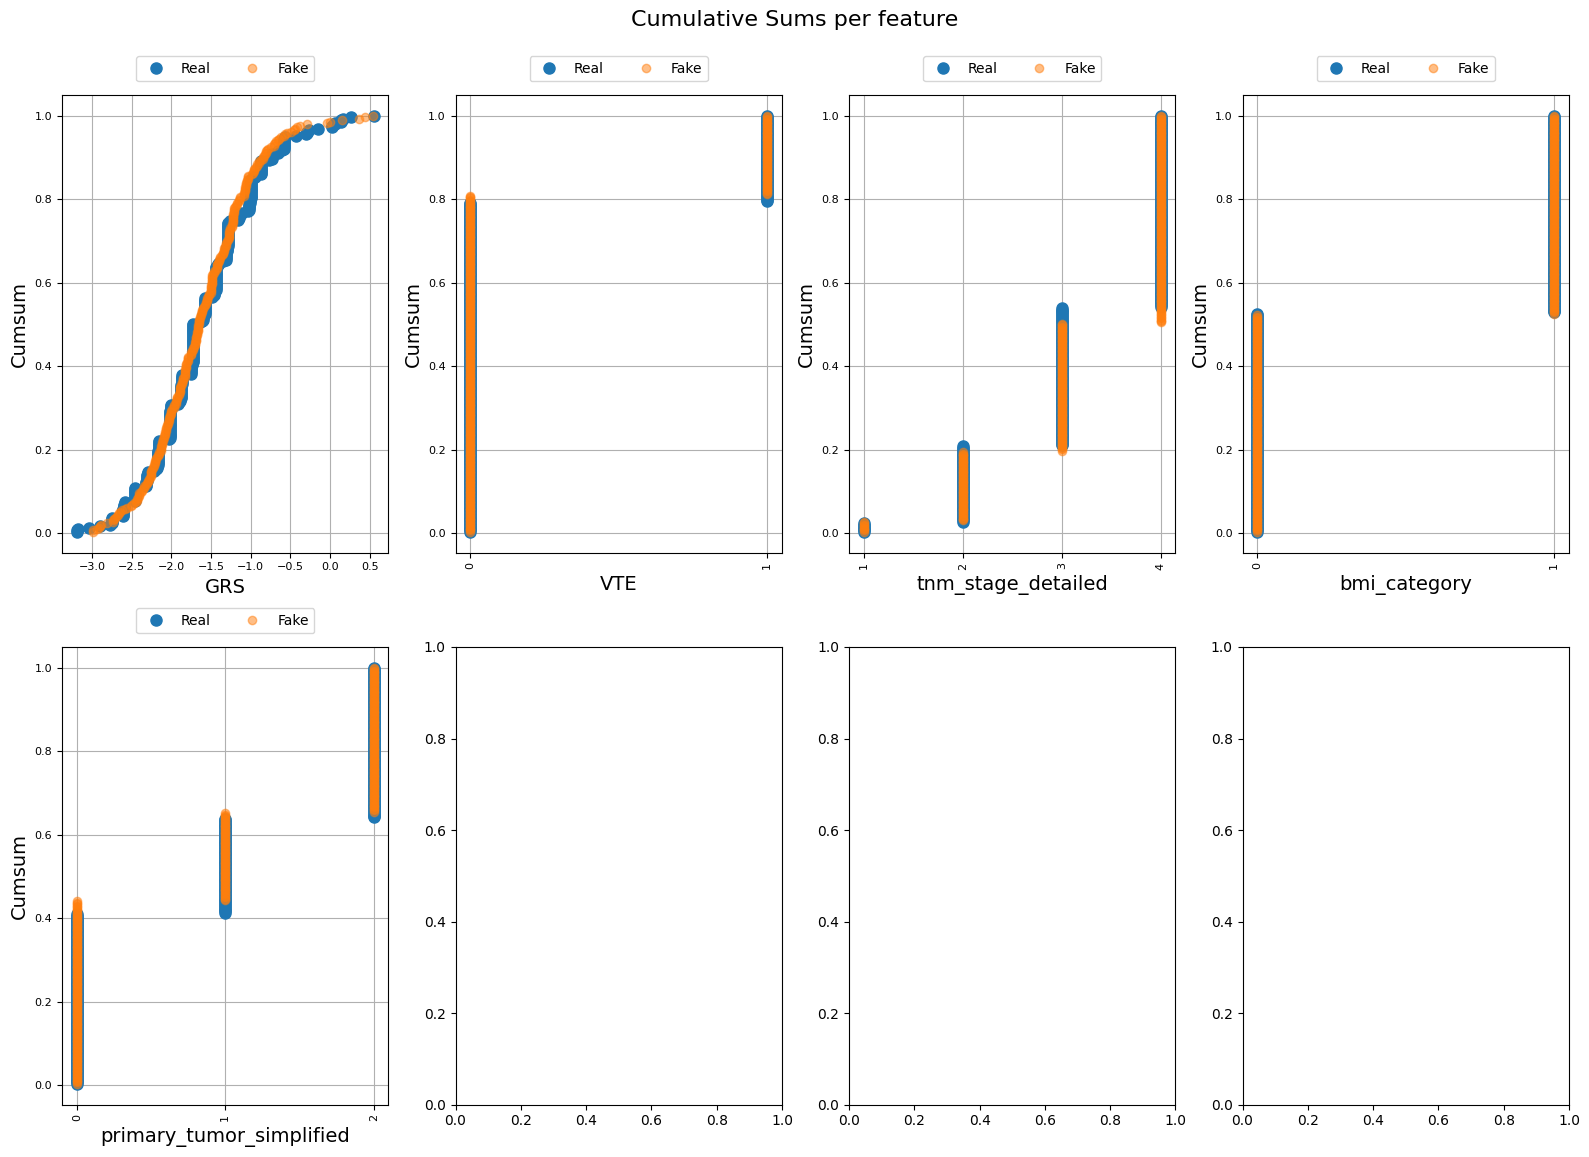

AttributeError: 'Series' object has no attribute 'append'

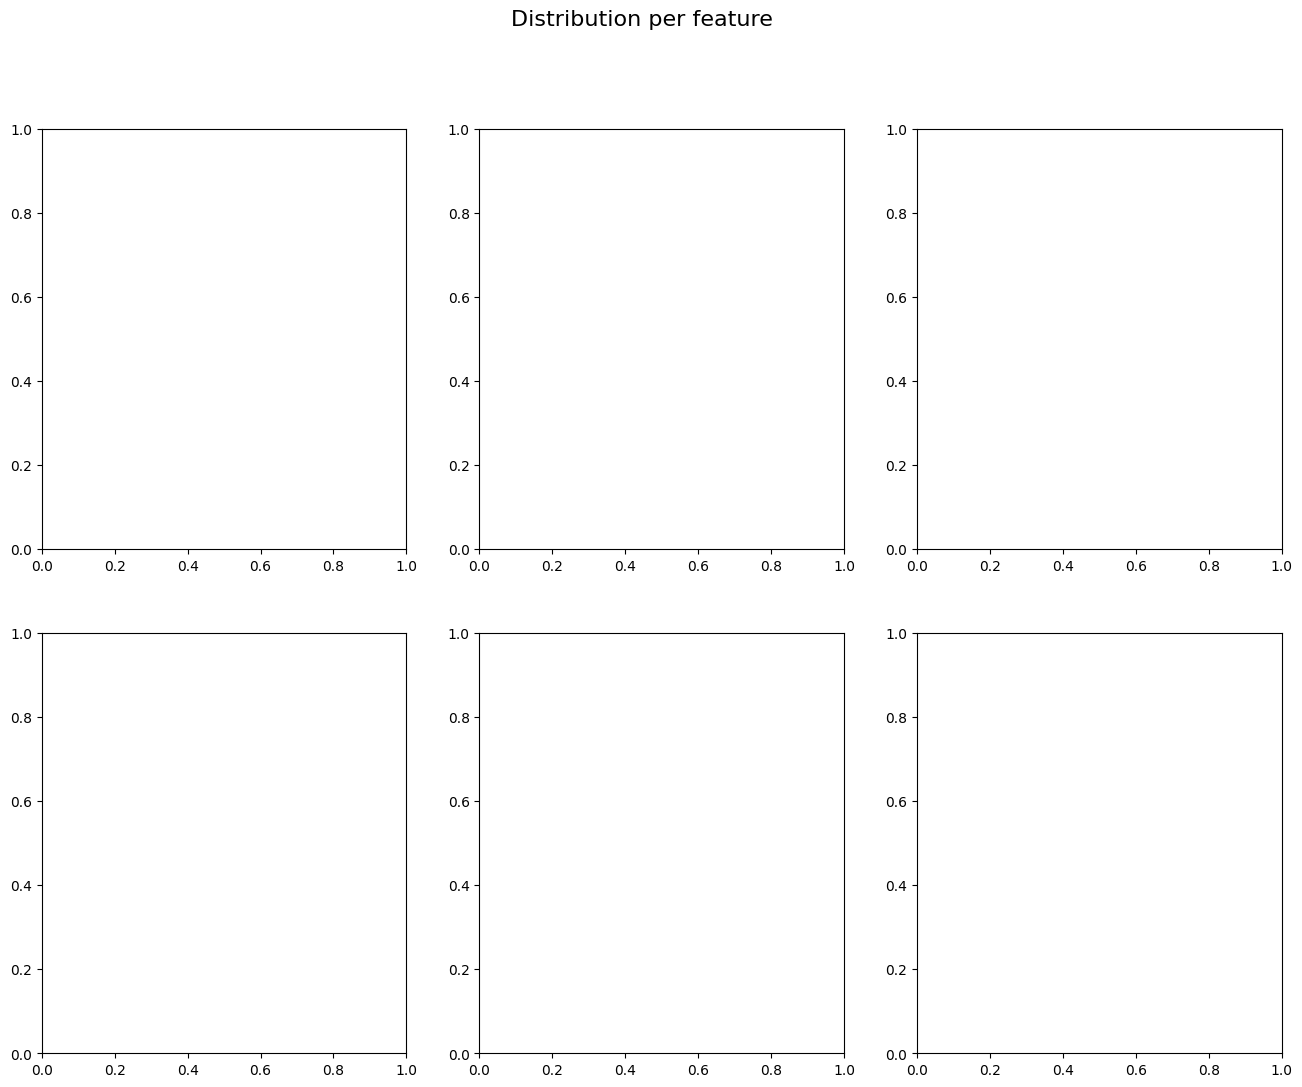

In [37]:
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(df_no_dupes, synth_gen, cat_cols = ['bmi_category', 'primary_tumor_simplified', 'VTE', 'tnm_stage_detailed'])
table_evaluator.visual_evaluation()

In [38]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synth_gen.drop('VTE', axis=1), synth_gen['VTE'], test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8241666666666667

In [39]:
y_pred = clf.predict(X_test)
auc_obs = roc_auc_score(y_test, y_pred)
print(auc_obs)

0.5329493144364085


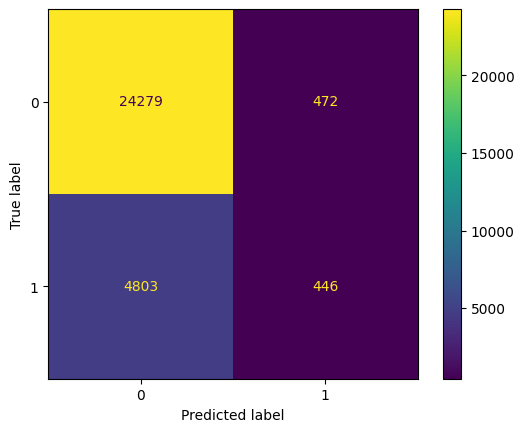

In [40]:
# Compute confusion matrix
cm = confusion_matrix(y_test.values, np.round(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [41]:
#Load data form baselines curves
roc_curve_onco = pd.read_csv('no_dups_roc_curve_oncothromb_score_replicated.csv')
pr_curve_onco = pd.read_csv('no_dups_pr_curve_oncothromb_score_replicated.csv')
roc_curve_orig = pd.read_csv('mean_roc_curve_from_cv_oncothromb.csv')
prc_curve_orig = pd.read_csv('pr_curve_oncothromb_score_replicated.csv')

C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


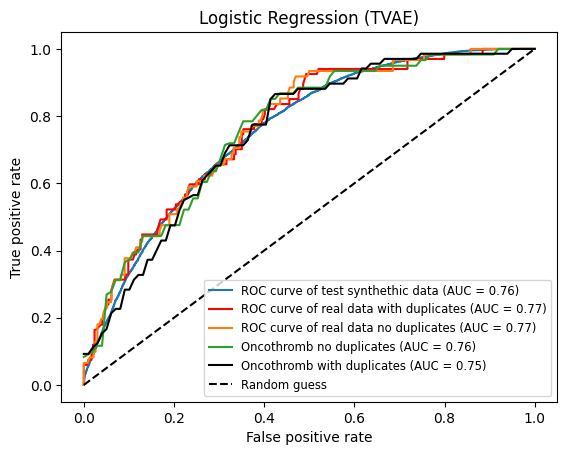

In [42]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
#fpr_2, tpr_2, thresholds_2 = roc_curve(y_points,pred_points)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_real_dupes,clf.predict_proba(X_real_dupes)[:,1])
fpr_4, tpr_4, thresholds_4 = roc_curve(y_real_no_dupes,clf.predict_proba(X_real_no_dupes)[:,1])


# Calculate the AUC value
auc_value = auc(fpr, tpr)
auc_value_2 = auc(fpr_3, tpr_3)
auc_value_5 = auc(fpr_4, tpr_4)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])


# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of test synthethic data (AUC = %0.2f)' % auc_value)
plt.plot(fpr_3, tpr_3, color='red',label='ROC curve of real data with duplicates (AUC = %0.2f)' % auc_value_2)
plt.plot(fpr_4, tpr_4,label='ROC curve of real data no duplicates (AUC = %0.2f)' % auc_value_5)
plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], label='Oncothromb no duplicates (AUC = %0.2f)' % auc_value_3)
plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'],color='black', label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression (TVAE)')
plt.legend(loc='lower right', fontsize='small')
# Save figure with higher DPI
#plt.savefig('ROC_curve_TVAE_new.png', dpi=300)
plt.show()


C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\SergiBech\anaconda3\envs\new_env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


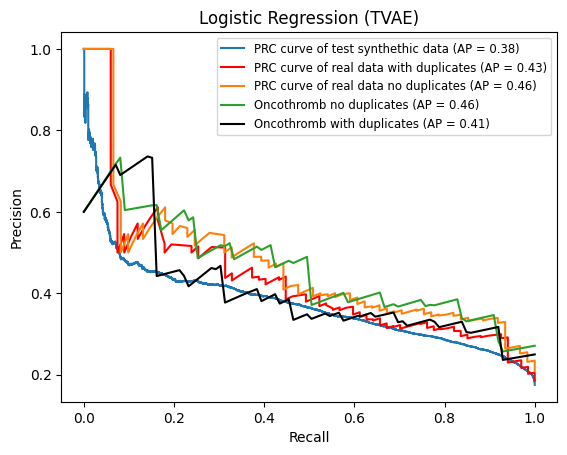

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision2, recall2, threshold2 = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

# Get precision, recall, and threshold values for real data
precision3, recall3, threshold3 = precision_recall_curve(y_real_dupes, clf.predict_proba(X_real_dupes)[:, 1])
precision4, recall4, threshold4 = precision_recall_curve(y_real_no_dupes, clf.predict_proba(X_real_no_dupes)[:, 1])


# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_2 = auc(recall2, precision2)
ap_3 = auc(recall3, precision3)
ap_5 = auc(recall4, precision4)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)


# Plot the test data Precision-Recall curve
ax.plot(recall2, precision2, label='PRC curve of test synthethic data (AP = %0.2f)' % ap_2)

# Plot the real data Precision-Recall curve
ax.plot(recall3, precision3, color='red', label='PRC curve of real data with duplicates (AP = %0.2f)' % ap_3)
ax.plot(recall4, precision4,  label='PRC curve of real data no duplicates (AP = %0.2f)' % ap_5)


# Plot the synthethic data Precision-Recall curve
ax.plot(pr_curve_onco.recall_points, pr_curve_onco.mean_precision, label='Oncothromb no duplicates (AP = %0.2f)' % ap)

ax.plot(prc_curve_orig.recall, prc_curve_orig.precision,color='black', label='Oncothromb with duplicates (AP = %0.2f)' % ap_4)

# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Logistic Regression (TVAE)")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
#plt.savefig('PRC_curve_TVAE_new.png', dpi=300)
plt.show()


# Train a Deep Learning Model with Synthethic Data

In [44]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(synth_gen.drop('VTE', axis=1), synth_gen['VTE'], test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def make_model(metrics=METRICS):

    # Define the MLP model with skip connections and dropout
    inputs = keras.layers.Input(shape=(X_train.shape[1],))
    
    x = keras.layers.Dense(units=128, activation='relu')(inputs)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(units=64, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    
   
    x = keras.layers.Dense(units=16, activation='relu')(x)
    
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model with the specified optimizer, loss function, and metrics
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss= keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics)

    return model

In [45]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=8,
    mode='max',
    restore_best_weights=True)

In [46]:
del model

In [47]:
model = make_model(metrics=METRICS)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    epochs=EPOCHS,
    validation_data=(X_test, y_test))

Epoch 1/100
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3878 - tp: 1861.0000 - fp: 1439.0000 - tn: 97704.0000 - fn: 18996.0000 - accuracy: 0.8297 - precision: 0.5639 - recall: 0.0892 - auc: 0.7747 - prc: 0.3965 - val_loss: 0.3827 - val_tp: 407.0000 - val_fp: 214.0000 - val_tn: 24537.0000 - val_fn: 4842.0000 - val_accuracy: 0.8315 - val_precision: 0.6554 - val_recall: 0.0775 - val_auc: 0.7856 - val_prc: 0.4208
Epoch 2/100
3750/3750 [==============================] - 13s 3ms/step - loss: 0.3811 - tp: 1898.0000 - fp: 1321.0000 - tn: 97822.0000 - fn: 18959.0000 - accuracy: 0.8310 - precision: 0.5896 - recall: 0.0910 - auc: 0.7846 - prc: 0.4130 - val_loss: 0.3825 - val_tp: 441.0000 - val_fp: 269.0000 - val_tn: 24482.0000 - val_fn: 4808.0000 - val_accuracy: 0.8308 - val_precision: 0.6211 - val_recall: 0.0840 - val_auc: 0.7845 - val_prc: 0.4173
Epoch 3/100
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3799 - tp: 1785.0000 - fp: 1194.0000 - tn: 979

Epoch 20/100
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3772 - tp: 1863.0000 - fp: 1171.0000 - tn: 97972.0000 - fn: 18994.0000 - accuracy: 0.8320 - precision: 0.6140 - recall: 0.0893 - auc: 0.7896 - prc: 0.4217 - val_loss: 0.3808 - val_tp: 543.0000 - val_fp: 376.0000 - val_tn: 24375.0000 - val_fn: 4706.0000 - val_accuracy: 0.8306 - val_precision: 0.5909 - val_recall: 0.1034 - val_auc: 0.7872 - val_prc: 0.4231
Epoch 21/100
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3775 - tp: 1829.0000 - fp: 1159.0000 - tn: 97984.0000 - fn: 19028.0000 - accuracy: 0.8318 - precision: 0.6121 - recall: 0.0877 - auc: 0.7891 - prc: 0.4204 - val_loss: 0.3802 - val_tp: 386.0000 - val_fp: 205.0000 - val_tn: 24546.0000 - val_fn: 4863.0000 - val_accuracy: 0.8311 - val_precision: 0.6531 - val_recall: 0.0735 - val_auc: 0.7867 - val_prc: 0.4236
Epoch 22/100
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3774 - tp: 1742.0000 - fp: 1100.0000 - tn: 

10/10 [==============================] - 0s 2ms/step


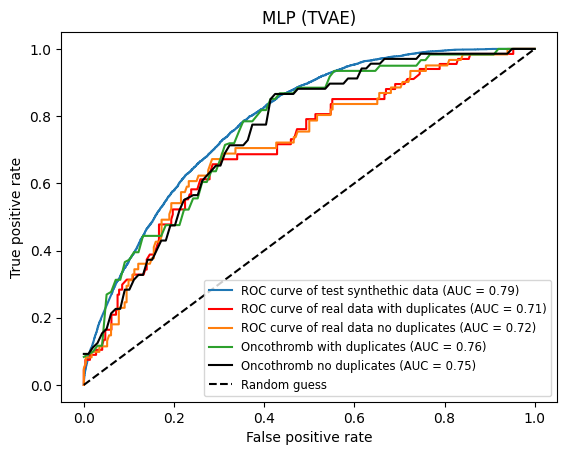

In [48]:
# Calculate the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test,model.predict(X_test))
fpr_3, tpr_3, thresholds_3 = roc_curve(y_real_dupes,model.predict(X_real_dupes))
fpr_4, tpr_4, thresholds_4 = roc_curve(y_real_no_dupes,model.predict(X_real_no_dupes))


# Calculate the AUC value
auc_value = auc(fpr, tpr)
auc_value_2 = auc(fpr_3, tpr_3)
auc_value_5 = auc(fpr_4, tpr_4)
auc_value_3 = auc(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'])
auc_value_4 = auc(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'])


# Plot the ROC curve and add the AUC value to the plot
plt.plot(fpr, tpr, label='ROC curve of test synthethic data (AUC = %0.2f)' % auc_value)
plt.plot(fpr_3, tpr_3,color='red', label='ROC curve of real data with duplicates (AUC = %0.2f)' % auc_value_2)
plt.plot(fpr_4, tpr_4, label='ROC curve of real data no duplicates (AUC = %0.2f)' % auc_value_5)

plt.plot(roc_curve_onco['fpr_points'], roc_curve_onco['mean_tpr'], label='Oncothromb with duplicates (AUC = %0.2f)' % auc_value_3)
plt.plot(roc_curve_orig['fpr_points'], roc_curve_orig['mean_tpr'], color='black',label='Oncothromb no duplicates (AUC = %0.2f)' % auc_value_4)

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('MLP (TVAE)')
plt.legend(loc='best', fontsize='small')

# Save figure with higher DPI
#plt.savefig('ROC_curve_MLP_copulaGAN.png', dpi=300)
plt.show()

10/10 [==============================] - 0s 2ms/step


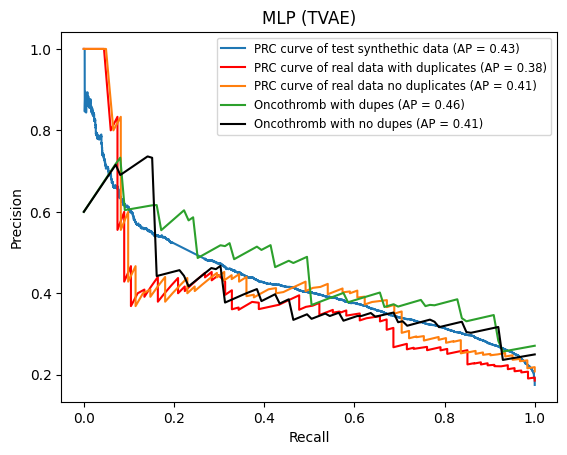

In [49]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and threshold values for test data
precision2, recall2, threshold2 = precision_recall_curve(y_test, model.predict(X_test))

# Get precision, recall, and threshold values for real data
precision3, recall3, threshold3 = precision_recall_curve(y_real_dupes, model.predict(X_real_dupes))
precision4, recall4, threshold4 = precision_recall_curve(y_real_no_dupes, model.predict(X_real_no_dupes))


# Create a new figure and axis object
fig, ax = plt.subplots()

ap = auc(pr_curve_onco.recall_points, pr_curve_onco.mean_precision)
ap_4 = auc(prc_curve_orig.recall, prc_curve_orig.precision)
ap_2 = auc(recall2, precision2)
ap_3 = auc(recall3, precision3)
ap_5 = auc(recall4, precision4)

# Plot the test data Precision-Recall curve
ax.plot(recall2, precision2, label='PRC curve of test synthethic data (AP = %0.2f)' % ap_2)

# Plot the real data Precision-Recall curve
ax.plot(recall3, precision3, color='red', label='PRC curve of real data with duplicates (AP = %0.2f)' % ap_3)
ax.plot(recall4, precision4, label='PRC curve of real data no duplicates (AP = %0.2f)' % ap_5)


# Plot the synthethic data Precision-Recall curve
ax.plot(pr_curve_onco.recall_points, pr_curve_onco.mean_precision, label='Oncothromb with dupes (AP = %0.2f)' % ap)

ax.plot(prc_curve_orig.recall, prc_curve_orig.precision,color='black', label='Oncothromb with no dupes (AP = %0.2f)' % ap_4)


# Set the x and y axis labels, title, and legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("MLP (TVAE)")
plt.legend(loc='best', fontsize='small')

# Save the figure and show it
#plt.savefig('PRC_curve_MLP_copulaGAN.png', dpi=300)
plt.show()